In [2]:
'''
GCPでプロジェクトを作成し、サービスアカウントの秘密鍵を作成のうえipynb実行箇所と同一階層に保存する
GCPでGoogle Earth Engine RESTを有効化する。
以下の環境変数
'''
import os
# os.environ['GCP_SERVICE_ACCOUNT'] = 'gee-service-account@xxxxx.iam.gserviceaccount.com'
# os.environ['GCP_KEY_FILE'] = 'xxxxx-aaaaa.json'
# os.environ['GCP_PROJECT_ID'] = 'xxxxx'

In [3]:
# REST APIのインポート（まれにインポートに時間がかかる場合あり）
from sentinelimagerest import SentinelImageREST

In [4]:
'''
変数を設定する
通常は以下の項目を入力する
coords : ポリゴン座標（経度、緯度）※最初と最後の座標は一致させること
start_date : 画像取得開始日
cloudy_pixel_percentage_limit : 画像取得終了日
output_image_dir : 画像保存場所（特に変更しなくても良い）
finename_prefix : 元画像内の雲発生割合上限値
'''

coords = [[
        [143.25916964884624, 43.20577096289138],
        [143.26094227838942, 43.20555456719537],
        [143.26087310260237, 43.20523102268399],
        [143.26029087306136, 43.205304555678175],
        [143.25992770017933, 43.20364478937389],
        [143.258711359257, 43.20378765711047],
        [143.25916964884624, 43.20577096289138]
    ]]
start_date = '2022-05-01'
end_date = '2022-07-31'
cloudy_pixel_percentage_limit = 50
output_image_dir = './'
finename_prefix = 'image'

# SentinelImageRESTクラスオブジェクトの作成
obj = SentinelImageREST(coords, start_date, end_date, cloudy_pixel_percentage_limit,output_image_dir,finename_prefix)

# 撮影日リスト取得
shootingdate_list = obj.get_shootingdate_list()
shootingdate_list

['2022-05-02',
 '2022-05-17',
 '2022-05-24',
 '2022-06-06',
 '2022-06-18',
 '2022-06-21',
 '2022-06-26',
 '2022-07-03']

In [5]:
# folium表示の初期設定

import folium
import numpy as np

def bounds_centroid(bounds):
    arr = np.array(bounds)
    return ((arr[0] + arr[1]) / 2).tolist()

initial_content = obj.get_ndvi_for_folium(shootingdate_list[0])

folium_map = folium.Map(
    location=bounds_centroid(initial_content['bounds']),
    zoom_start=15,
)

folium.raster_layers.TileLayer(
    tiles='http://{s}.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='google',
    name='google maps',
    subdomains=['mt0', 'mt1', 'mt2', 'mt3'],
    overlay=False,
    control=True,
).add_to(folium_map)


folium.raster_layers.TileLayer(
    tiles='https://soil-inventory.rad.naro.go.jp/tile/figure/{z}/{x}/{y}.png',
    attr='soil-inventory',
    name='土壌図',
    overlay=True,
    control=True,
).add_to(folium_map)


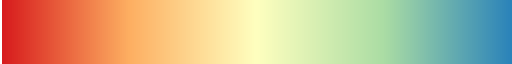

In [6]:
# VI値を表現するカラーパレットの作成

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def gen_cmap_rgb(cols):
    nmax = float(len(cols)-1)
    cdict = {'red':[], 'green':[], 'blue':[]}
    for n, c in enumerate(cols):
        loc = n/nmax
        cdict['red'  ].append((loc, c[0], c[0]))
        cdict['green'].append((loc, c[1], c[1]))
        cdict['blue' ].append((loc, c[2], c[2]))
    my_cmap = mpl.colors.LinearSegmentedColormap('cmap', cdict)
    func_cmap = lambda x : my_cmap(x)
    my_cmap = func_cmap(np.arange(my_cmap.N))
    my_cmap[0] = ((1, 1, 1, 0))
    return ListedColormap(my_cmap)

# カラーパレットをRGB値で記述（下記の例はQGIS　spectralと同一パレット）
red = (215,25,28)
orange = (253,174,97)
yellow = (255,255,191)
green = (171,221,164)
blue = (42,131,186)
color_pallet = [red,orange,yellow,green,blue]

my_cmap = gen_cmap_rgb(list(map(lambda x: tuple(map(lambda y: y/255,x)),color_pallet)))
my_cmap

In [7]:
# 撮影日リスト取得に基づき画像取得しfoliumレイヤーに追加
for idx,shootingdate in enumerate(shootingdate_list):
    
    content = obj.get_ndvi_for_folium(shootingdate)
    
    image = folium.raster_layers.ImageOverlay(
            image = content['image'], 
            bounds= content['bounds'],
            colormap = my_cmap,
            name = shootingdate,
            interactive=True,
            zindex=1,
        )

    image.add_to(folium_map)
    print(idx+1,'/',len(shootingdate_list),'added...')

print('finished')

1 / 8 added...
2 / 8 added...
3 / 8 added...
4 / 8 added...
5 / 8 added...
6 / 8 added...
7 / 8 added...
8 / 8 added...
finished


In [8]:
# foliumでの表示
folium.LayerControl(collapsed=False).add_to(folium_map)
folium_map

In [10]:
# Geotiff各VI画像（オプションでバッファーを指定、初期値は0、正：拡大、負：縮小）
# obj.get_geotiff_raw()
# obj.get_geotiff_vi('EVI2',-10)
# obj.get_geotiff_vi('NDVI')
# obj.get_geotiff_vi('NDWI')

download EVI2 GeoTIFF... 1 / 8
download EVI2 GeoTIFF... 2 / 8
download EVI2 GeoTIFF... 3 / 8
download EVI2 GeoTIFF... 4 / 8
download EVI2 GeoTIFF... 5 / 8
download EVI2 GeoTIFF... 6 / 8
download EVI2 GeoTIFF... 7 / 8
download EVI2 GeoTIFF... 8 / 8
download NDVI GeoTIFF... 1 / 8
download NDVI GeoTIFF... 2 / 8
download NDVI GeoTIFF... 3 / 8
download NDVI GeoTIFF... 4 / 8
download NDVI GeoTIFF... 5 / 8
download NDVI GeoTIFF... 6 / 8
download NDVI GeoTIFF... 7 / 8
download NDVI GeoTIFF... 8 / 8
